In [1]:
import Thermobar as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import load
import pickle

## Loading machine learning model

In [2]:
with open('svc_model_linear_MinClass.pkl', 'rb') as f:
        svc_model=load(f)
with open('scaler_MinClass.pkl', 'rb') as f:
        scaler=load(f)

In [3]:
def classify_phases(filename, sheet_name, return_end_members=False):
    Excel_In=pt.import_excel(filename, sheet_name)
    Oxides=Excel_In['my_oxides']
    with open('svc_model_linear_MinClass.pkl', 'rb') as f:
        svc_model=load(f)
    with open('scaler_MinClass.pkl', 'rb') as f:
        scaler=load(f)  
        
    # Dropping things which are often missing
    Oxides_dropoxides=Oxides.drop(columns=['Cr2O3', 'K2O', 'P2O5'])
    X_in=Oxides_dropoxides.values
    
    ## This does the machine learning classification
    X_in_scaled= scaler.transform(X_in)
    svc_predictions=svc_model.predict(X_in_scaled) 
    Oxides_out=Oxides.copy()
    Oxides_out['Sum_Oxides']=Oxides.sum(axis=1)
    Oxides_out['Phase_Min_Group_ML']=svc_predictions
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(0, "Amp")    
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(1, "Px")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(2, "Fspar")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(3, "Ol")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(4, "Sp")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(5, "Ox")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(6, "Ap")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(7, "Bt")
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(8, "Qz")    
    Oxides_out[['Phase_Min_Group_ML']]=Oxides_out[['Phase_Min_Group_ML']].replace(9, "Gt")

    
    Oxides_out.loc[Oxides_out['Sum_Oxides']<90, 'Phase_Min_Group_ML'] = "Not Classified - Total<90"    
    Oxides_out.loc[Oxides_out['Sum_Oxides']>110, 'Phase_Min_Group_ML'] = "Not Classified - Total>110"
    Oxides_out['Phase_Mineral']=Oxides_out['Phase_Min_Group_ML']
    
    #This does manual classification for feldsdpars.
    Fspar=Oxides_out['Phase_Min_Group_ML']=="Fspar" # This checks we are only doing it for felspar
    Oxides_Fspar=Oxides_out.add_suffix('_Plag')
    Fspar_components=pt.calculate_cat_fractions_plagioclase(plag_comps=Oxides_Fspar)
    Fspar_An=Fspar_components['An_Plag']
    Fspar_Ab=Fspar_components['Ab_Plag']
    Fspar_Or=Fspar_components['Or_Plag']  
    if return_end_members==True:
        Oxides_out['Ab']=Fspar_Ab
        Oxides_out.loc[Oxides_out['Phase_Min_Group_ML']!="Fspar", 'Ab']="N/A"
        Oxides_out['An']=Fspar_An
        Oxides_out.loc[Oxides_out['Phase_Min_Group_ML']!="Fspar", 'An']="N/A"
        Oxides_out['Or']=Fspar_Or
        Oxides_out.loc[Oxides_out['Phase_Min_Group_ML']!="Fspar", 'Or']="N/A"
        
    Oxides_out.loc[( (Fspar) & (Fspar_An>0.1) & (Fspar_Or<0.1) ), 'Phase_Mineral'] = "Plag"    
    Oxides_out.loc[( (Fspar) & (Fspar_Or>0.1) & (Fspar_An<0.1)), 'Phase_Mineral'] = "Kspar"    
    Oxides_out.loc[(Fspar & (Fspar_An<0.1) &  (Fspar_Or<0.1)), 'Phase_Mineral'] = "Albite"      
    
    Oxides_out['Fspar_Class']=Oxides_out['Phase_Min_Group_ML']

    Oxides_out.loc[( (Fspar) & (Fspar_An<0.1) &  (Fspar_Or<0.1) ), 'Fspar_Class'] = "Albite"                        
    Oxides_out.loc[( (Fspar) & (Fspar_Or.between(0.1, 0.37) ) &  (Fspar_An<0.2)), 'Fspar_Class'] = "Anorthoclase"                        
    Oxides_out.loc[( (Fspar) & (Fspar_Or>0.37) &  (Fspar_An<0.2) ), 'Fspar_Class'] = "Sanidine"                        
    Oxides_out.loc[( (Fspar) & (Fspar_An.between(0.1, 0.3)) &  (Fspar_Or<0.1) ), 'Fspar_Class'] = "Oligoclase"                        
    Oxides_out.loc[( (Fspar) & (Fspar_An.between(0.3, 0.5)) &  (Fspar_Or<0.1) ), 'Fspar_Class'] = "Andesine"                        
    Oxides_out.loc[( (Fspar) & (Fspar_An.between(0.5, 0.7)) &  (Fspar_Or<0.1) ), 'Fspar_Class'] = "Bytownite"                        
    Oxides_out.loc[( (Fspar) & (Fspar_An>0.9) &  (Fspar_Or<0.1) ), 'Fspar_Class'] = "Anorthite"                        
    Oxides_out.loc[Oxides_out['Phase_Min_Group_ML']!="Fspar", 'Fspar_Class']="N/A"
    
    # This does Manual Classification for Pyroxenes
    Oxides_Pyroxenes=Oxides_out.add_suffix('_Opx')
    Px=Oxides_out['Phase_Min_Group_ML']=="Px"

    Px_components=pt.calculate_orthopyroxene_components(opx_comps=Oxides_Pyroxenes)
    Px_CaMgFe=Px_components['Ca_CaMgFe']
    Oxides_out.loc[( (Px) & (Px_CaMgFe<0.05) ), 'Phase_Mineral'] = "Opx"     
    Oxides_out.loc[( (Px) & (Px_CaMgFe.between(0.05, 0.2)) ), 'Phase_Mineral'] = "Pig"     
    Oxides_out.loc[( (Px) & (Px_CaMgFe>0.2) ), 'Phase_Mineral'] = "Cpx" 
    if return_end_members==True:
        Oxides_out['Ca/CaMgFe Px']=Px_CaMgFe
        Oxides_out.loc[Oxides_out['Phase_Min_Group_ML']!="Px", 'Ca/CaMgFe']="N/A"    

    # This does manual classification for amphiboles, based on Leake (1997)
    
    
    return Oxides_out

## Amphibole GEOROC download - 16th August

In [4]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')
    GEOROC_Amp_in=pt.import_excel('GEOROC_Test_Amphibole.xlsx', sheet_name="AMPHIBOLES_reform")
    GEOROC_Amp_input=GEOROC_Amp_in['my_input']
    GEOROC_Amp_PreFilt=GEOROC_Amp_in['my_oxides']

In [5]:
GEOROC_Amp_input['TECTONIC SETTING'].unique()

array(['OCEAN ISLAND', 'INTRAPLATE VOLCANICS', 'RIFT VOLCANICS',
       'SEAMOUNT', 'CONVERGENT MARGIN', 'CONTINENTAL FLOOD BASALT', nan,
       'OCEANIC PLATEAU', 'SUBMARINE RIDGE', 'OCEAN-BASIN FLOOD BASALT',
       'ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)',
       'COMPLEX VOLCANIC SETTINGS'], dtype=object)

In [6]:
GEOROC_Amp_copy=GEOROC_Amp_PreFilt.copy()
GEOROC_Amp_copy['Sum_Oxides']=GEOROC_Amp_PreFilt.sum(axis=1)
GEOROC_Amp_copy['Sum_Oxides']
GEOROC_Amp=GEOROC_Amp_PreFilt.loc[(GEOROC_Amp_copy['Sum_Oxides']>70) & 
                                  (GEOROC_Amp_input['TECTONIC SETTING']!= "ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)")
                                 & (GEOROC_Amp_input['TECTONIC SETTING']!= "nan")]
GEOROC_Amp.to_excel('GEOROC_Test_Amphibole_Filt.xlsx', sheet_name='Filtered')

In [7]:
print('Initial length')
print(len(GEOROC_Amp_PreFilt))
print('Filt length')
print(len(GEOROC_Amp))


Initial length
48528
Filt length
40041


In [8]:
Amp=classify_phases('GEOROC_Test_Amphibole_Filt.xlsx', sheet_name='Filtered', return_end_members=True)
Amp.head()

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,P2O5,Sum_Oxides,Phase_Min_Group_ML,Phase_Mineral,Ab,An,Or,Fspar_Class,Ca/CaMgFe Px,Ca/CaMgFe
0,41.4,2.86,14.80,12.13,0.16,13.79,10.90,3.05,0.81,0.00,0.08,99.98,Amp,Amp,N/A,N/A,N/A,N/A,0.275570,N/A
1,45.7,0.65,8.71,3.79,0.05,19.70,12.50,3.54,0.57,1.57,0.00,96.78,Amp,Amp,N/A,N/A,N/A,N/A,0.291595,N/A
2,43.0,3.17,12.40,5.22,0.08,16.60,11.80,3.13,0.87,1.70,0.00,97.97,Amp,Amp,N/A,N/A,N/A,N/A,0.302792,N/A
3,42.0,4.88,11.60,5.45,0.05,15.80,12.00,3.12,0.87,1.68,0.00,97.45,Amp,Amp,N/A,N/A,N/A,N/A,0.313831,N/A
4,36.6,0.02,22.80,6.25,0.04,21.40,0.54,4.92,1.67,0.01,0.00,94.25,Amp,Amp,N/A,N/A,N/A,N/A,0.015344,N/A


In [9]:
Amp_not_Classified=Amp.loc[Amp['Phase_Min_Group_ML'] == "Not Classified - Total<90"]
Amp_not_Classified.head()

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,P2O5,Sum_Oxides,Phase_Min_Group_ML,Phase_Mineral,Ab,An,Or,Fspar_Class,Ca/CaMgFe Px,Ca/CaMgFe
29,34.40,3.71,14.30,0.00,0.17,9.23,12.46,3.09,1.60,0.0,0.84,79.80,Not Classified - Total<90,Not Classified - Total<90,N/A,N/A,N/A,N/A,0.492449,N/A
118,34.02,0.61,2.98,34.02,1.22,0.18,12.76,0.79,0.06,0.0,0.00,86.64,Not Classified - Total<90,Not Classified - Total<90,N/A,N/A,N/A,N/A,0.322518,N/A
365,48.20,1.40,5.70,0.00,0.00,9.90,10.60,1.20,0.70,0.0,0.00,77.70,Not Classified - Total<90,Not Classified - Total<90,N/A,N/A,N/A,N/A,0.434884,N/A
593,37.52,0.46,3.13,32.60,0.00,5.04,0.65,0.47,2.70,0.0,0.00,82.57,Not Classified - Total<90,Not Classified - Total<90,N/A,N/A,N/A,N/A,0.019633,N/A
710,41.80,2.38,11.57,0.00,0.18,14.69,11.41,2.37,0.22,0.0,0.00,84.62,Not Classified - Total<90,Not Classified - Total<90,N/A,N/A,N/A,N/A,0.358254,N/A


In [10]:
Amp_Classified=Amp.loc[Amp['Phase_Min_Group_ML'] != "Not Classified - Total<90"]

In [11]:
sum(Amp_Classified['Phase_Min_Group_ML']!="Amp")

8195

In [12]:
Amp_Classifed_Right=Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML']=="Amp"]
Amp_Classifed_Right

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,P2O5,Sum_Oxides,Phase_Min_Group_ML,Phase_Mineral,Ab,An,Or,Fspar_Class,Ca/CaMgFe Px,Ca/CaMgFe
0,41.400,2.860,14.800,12.130,0.160,13.790,10.900,3.050,0.810,0.00,0.080,99.980,Amp,Amp,N/A,N/A,N/A,N/A,0.275570,N/A
1,45.700,0.650,8.710,3.790,0.050,19.700,12.500,3.540,0.570,1.57,0.000,96.780,Amp,Amp,N/A,N/A,N/A,N/A,0.291595,N/A
2,43.000,3.170,12.400,5.220,0.080,16.600,11.800,3.130,0.870,1.70,0.000,97.970,Amp,Amp,N/A,N/A,N/A,N/A,0.302792,N/A
3,42.000,4.880,11.600,5.450,0.050,15.800,12.000,3.120,0.870,1.68,0.000,97.450,Amp,Amp,N/A,N/A,N/A,N/A,0.313831,N/A
4,36.600,0.020,22.800,6.250,0.040,21.400,0.540,4.920,1.670,0.01,0.000,94.250,Amp,Amp,N/A,N/A,N/A,N/A,0.015344,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39989,47.120,1.450,6.620,14.482,0.380,14.070,11.830,1.590,0.610,0.00,0.000,98.152,Amp,Amp,N/A,N/A,N/A,N/A,0.276986,N/A
39990,47.170,1.500,6.470,14.290,0.400,14.070,11.730,1.600,0.670,0.00,0.000,97.900,Amp,Amp,N/A,N/A,N/A,N/A,0.276261,N/A
39994,47.900,1.580,6.120,13.808,0.320,14.320,11.680,1.580,0.560,0.00,0.000,97.868,Amp,Amp,N/A,N/A,N/A,N/A,0.275592,N/A
40022,44.700,1.348,8.710,17.681,0.396,10.967,11.944,1.039,0.933,0.00,0.000,97.718,Amp,Amp,N/A,N/A,N/A,N/A,0.291294,N/A


In [13]:
Amp_Classifed_Wrong=Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML']!="Amp"]
Amp_Classifed_Wrong

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,P2O5,Sum_Oxides,Phase_Min_Group_ML,Phase_Mineral,Ab,An,Or,Fspar_Class,Ca/CaMgFe Px,Ca/CaMgFe
33,45.740,0.260,0.990,35.570,2.100,0.270,11.200,0.280,0.220,0.000,0.000,96.630,Px,Cpx,N/A,N/A,N/A,N/A,0.284707,NaN
47,49.790,0.320,0.900,17.740,0.880,12.910,11.610,1.650,0.170,0.000,0.000,95.970,Px,Cpx,N/A,N/A,N/A,N/A,0.267396,NaN
72,51.520,0.330,6.650,3.670,0.140,15.880,19.500,1.360,0.000,0.820,0.000,99.870,Px,Cpx,N/A,N/A,N/A,N/A,0.438605,NaN
73,51.360,0.870,3.000,6.600,0.180,15.150,21.330,0.540,0.000,0.870,0.000,99.900,Px,Cpx,N/A,N/A,N/A,N/A,0.448483,NaN
74,48.210,2.360,6.380,5.950,0.090,13.790,22.740,0.440,0.000,0.840,0.000,100.800,Px,Cpx,N/A,N/A,N/A,N/A,0.488289,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40036,47.240,1.110,7.430,16.860,0.580,10.580,11.370,1.090,0.480,0.000,0.000,96.740,Px,Cpx,N/A,N/A,N/A,N/A,0.289682,NaN
40037,48.850,1.161,6.236,12.359,0.405,14.306,11.930,0.938,0.385,0.024,0.005,96.599,Px,Cpx,N/A,N/A,N/A,N/A,0.287601,NaN
40038,48.094,0.879,7.019,13.154,0.441,13.741,12.132,1.068,0.465,0.038,0.000,97.031,Px,Cpx,N/A,N/A,N/A,N/A,0.292215,NaN
40039,48.711,0.886,6.534,13.339,0.462,13.723,12.161,1.027,0.428,0.035,0.022,97.328,Px,Cpx,N/A,N/A,N/A,N/A,0.291870,NaN


## Accuracy

In [14]:
len(Amp_Classifed_Right)/(len(Amp_Classifed_Wrong)+len(Amp_Classifed_Right))

0.7939246108582493

In [15]:
len(Amp_Classifed_Wrong)

8195

In [16]:
## what did it classify as 
print('Classified as Px')
print(len(Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Px"]))
print('Classified as Ol')
print(len(Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Ol"]))
print('Classified as Plag')
print(len(Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Plag"]))
print('Classified as Gt')
print(len(Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Gt"]))
print('Classified as Ap')
print(len(Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Ap"]))
print('Classified as Sp')
print(len(Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Sp"]))
print('Classified as Ox')
print(len(Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Ox"]))
print('Classified as Qz')
print(len(Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Qz"]))
print('Classified as Bt')
print(len(Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Bt"]))

Classified as Px
8107
Classified as Ol
33
Classified as Plag
0
Classified as Gt
0
Classified as Ap
0
Classified as Sp
0
Classified as Ox
0
Classified as Qz
0
Classified as Bt
0


In [17]:
Amp_Classified_Px=Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Px"]
Amp_Classified_Ol=Amp_Classified.loc[Amp_Classified['Phase_Min_Group_ML'] =="Ol"]

## Loading cali data

In [18]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')
    LEPR_Amp_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Amp")
    LEPR_Amp_PreFilt=LEPR_Amp_in['Amps']

LEPR_Amp_Sums=pt.calculate_23oxygens_amphibole(amp_comps=LEPR_Amp_PreFilt).cation_sum_All
LEPR_Amp=LEPR_Amp_PreFilt.loc[LEPR_Amp_Sums.between(15.5, 16)]
LEPR_Amp_nosuf=LEPR_Amp.copy()
LEPR_Amp_nosuf.drop(columns=['F_Amp', 'Cl_Amp'], inplace=True)
LEPR_Amp_nosuf.columns = [col.replace('_Amp', '') for col in LEPR_Amp_nosuf.columns]
LEPR_Amp_nosuf['Phase']=0

In [19]:
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')    
    LEPR_Ol_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Ol")
    LEPR_px_input=LEPR_Ol_in['my_input']
    LEPR_Ol_PreFilt=LEPR_Ol_in['Ols']


LEPR_Ol=LEPR_Ol_PreFilt


LEPR_Ol_nosuf=LEPR_Ol.copy()
LEPR_Ol_nosuf.columns = [col.replace('_Ol', '') for col in LEPR_Ol_nosuf.columns]

LEPR_Ol_nosuf['Phase']=3

# Plot misclassified against GEOROC

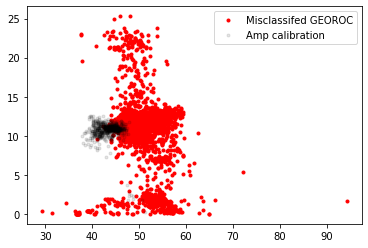

In [20]:
plt.plot(Amp_Classifed_Wrong['SiO2'], Amp_Classifed_Wrong['CaO'], '.r', label='Misclassifed GEOROC')
plt.plot(LEPR_Amp_nosuf['SiO2'], LEPR_Amp_nosuf['CaO'], '.k', alpha=0.1, label='Amp calibration')
plt.legend()

In [21]:
a=3.95
b=4.95
import warnings as w
with w.catch_warnings():
    w.simplefilter('ignore')
    LEPR_Cpx_in=pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Cpx")
    LEPR_px_input=LEPR_Cpx_in['my_input']
    LEPR_Cpx_PreFilt=LEPR_Cpx_in['Cpxs']

LEPR_Cpx_cs=pt.calculate_clinopyroxene_components(cpx_comps=LEPR_Cpx_PreFilt)
LEPR_Cpx_Sums=LEPR_Cpx_cs.Cation_Sum_Cpx
LEPR_CaCaMgFe=LEPR_Cpx_cs.Ca_CaMgFe
LEPR_Cpx=LEPR_Cpx_PreFilt.loc[(LEPR_Cpx_Sums.between(a, b))]
LEPR_Cpx_nosuf=LEPR_Cpx.copy()
LEPR_Cpx_nosuf.columns = [col.replace('_Cpx', '') for col in LEPR_Cpx_nosuf.columns]
LEPR_Cpx_nosuf['Phase']=1


made it to forloop


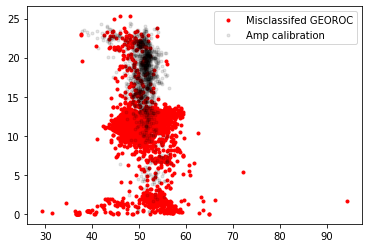

In [22]:
plt.plot(Amp_Classifed_Wrong['SiO2'], Amp_Classifed_Wrong['CaO'], '.r', label='Misclassifed GEOROC')
plt.plot(LEPR_Cpx_nosuf['SiO2'], LEPR_Cpx_nosuf['CaO'], '.k', alpha=0.1, label='Amp calibration')
plt.legend()

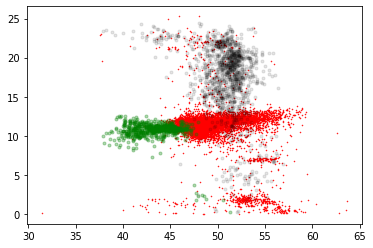

In [23]:

plt.plot(Amp_Classified_Px['SiO2'], Amp_Classified_Px['CaO'], '.r', label='Misclassifed GEOROC', ms=1)
plt.plot(LEPR_Cpx_nosuf['SiO2'], LEPR_Cpx_nosuf['CaO'], '.k', alpha=0.1, label='LEPR Cpx calibration')
plt.plot(LEPR_Amp_nosuf['SiO2'], LEPR_Amp_nosuf['CaO'], '.g', alpha=0.3, label='LEPR Amp calibration')

#plt.legend()

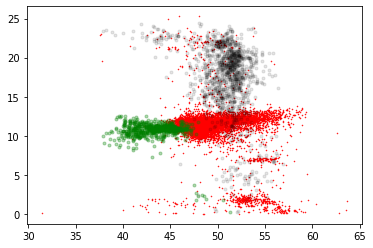

In [24]:

plt.plot(Amp_Classified_Px['SiO2'], Amp_Classified_Px['CaO'], '.r', label='Misclassifed GEOROC', ms=1)
plt.plot(LEPR_Cpx_nosuf['SiO2'], LEPR_Cpx_nosuf['CaO'], '.k', alpha=0.1, label='LEPR Cpx calibration')
plt.plot(LEPR_Amp_nosuf['SiO2'], LEPR_Amp_nosuf['CaO'], '.g', alpha=0.3, label='LEPR Amp calibration')

#plt.legend()

## Is it anything to do with totals?

In [27]:
GEOROC_Amp_suffix=GEOROC_Amp.add_suffix('_Amp')


In [29]:

GEOROC_Amp_suffix_reset=GEOROC_Amp_suffix.reset_index(drop=True)
GEOROC_Amp_suffix_reset_cpx=GEOROC_Amp_suffix_reset.copy()
GEOROC_Amp_suffix_reset_cpx.columns = [col.replace('_Amp', '_Cpx') for col in GEOROC_Amp_suffix_reset_cpx.columns]
GEOROC_Amp_suffix_reset_cpx

,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,P2O5_Cpx
0,41.400,2.860,14.800,12.130,0.160,13.790,10.900,3.050,0.810,0.000,0.080
1,45.700,0.650,8.710,3.790,0.050,19.700,12.500,3.540,0.570,1.570,0.000
2,43.000,3.170,12.400,5.220,0.080,16.600,11.800,3.130,0.870,1.700,0.000
3,42.000,4.880,11.600,5.450,0.050,15.800,12.000,3.120,0.870,1.680,0.000
4,36.600,0.020,22.800,6.250,0.040,21.400,0.540,4.920,1.670,0.010,0.000
...,...,...,...,...,...,...,...,...,...,...,...
40036,47.240,1.110,7.430,16.860,0.580,10.580,11.370,1.090,0.480,0.000,0.000
40037,48.850,1.161,6.236,12.359,0.405,14.306,11.930,0.938,0.385,0.024,0.005
40038,48.094,0.879,7.019,13.154,0.441,13.741,12.132,1.068,0.465,0.038,0.000
40039,48.711,0.886,6.534,13.339,0.462,13.723,12.161,1.027,0.428,0.035,0.022


In [30]:
GEOROC_Amp_Sums=pt.calculate_23oxygens_amphibole(amp_comps=GEOROC_Amp_suffix_reset).cation_sum_All
print('done amp')

done amp


In [31]:
#LEPR_Amp=LEPR_Amp_PreFilt.loc[LEPR_Amp_Sums.between(15.5, 16)]
GEOROC_Amp_cpx_sums=pt.calculate_clinopyroxene_components(cpx_comps=GEOROC_Amp_suffix_reset_cpx)

made it to forloop


In [ ]:
GEOROC_Amp_Sums=pt.calculate_23oxygens_amphibole(amp_comps=GEOROC_Amp_suffix_reset).cation_sum_All
print('done amp')
#LEPR_Amp=LEPR_Amp_PreFilt.loc[LEPR_Amp_Sums.between(15.5, 16)]
GEOROC_Amp_cpx_sums=pt.calculate_clinopyroxene_components(cpx_comps=GEOROC_Amp_suffix_reset_cpx).Cation_Sum_Cpx
#LEPR_Amp=LEPR_Amp_PreFilt.loc[LEPR_Amp_Sums.between(15.5, 16)]
print('done cpx')

In [ ]:
Amp['Amp_Sums']=GEOROC_Amp_Sums
Amp['Cpx_Sums']=GEOROC_Amp_cpx_sums

In [ ]:
Amp['Amp_Sums']=GEOROC_Amp_Sums

In [ ]:
plt.hist(Amp.loc[Amp['Phase_Min_Group_ML']=="Amp", "Amp_Sums" ], color='green')
plt.hist(Amp.loc[Amp['Phase_Min_Group_ML']=="Px", "Amp_Sums" ], alpha=0.7, color='red')

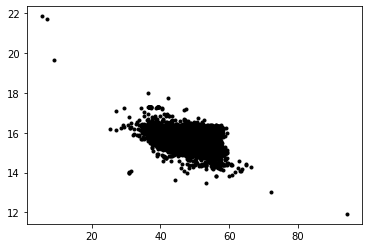

In [146]:
plt.plot(Amp['SiO2'], Amp['Amp_Sums'], '.k')

In [133]:
Amp.loc[Amp['Phase_Min_Group_ML']=="Px", "LEPR_Amp_Sums" ]

33       15.313315
47       15.540374
72       15.391754
73       15.389683
74       15.413260
           ...    
40036    15.329443
40037    15.317864
40038    15.403550
40039    15.369122
40040    15.506240
Name: LEPR_Amp_Sums, Length: 8107, dtype: float64